*MEMO :: this codes based on tvm docker *

1)install cuda docker
https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker


```
(install nvidia driver first, )
$>distribution=$(. /etc/os-release;echo $ID$VERSION_ID)    && curl -s -L https://nvidia.github.io/nvidia-docker/gpgkey | sudo apt-key add -    && curl -s -L https://nvidia.github.io/nvidia-docker/$distribution/nvidia-docker.list | sudo tee /etc/apt/sources.list.d/nvidia-docker.list

$>curl -s -L https://nvidia.github.io/nvidia-container-runtime/experimental/$distribution/nvidia-container-runtime.list | sudo tee /etc/apt/sources.list.d/nvidia-container-runtime.list

$>sudo apt-get update
$>sudo apt-get install -y nvidia-docker2
$>sudo systemctl restart docker
$>sudo docker run --rm --gpus all nvidia/cuda:11.0-base nvidia-smi
```

2)build tvm docker
https://tvm.apache.org/docs/install/docker.html
```
$>git clone --recursive https://github.com/apache/tvm tvm
$>cd tvm
$>sudo ./docker/build.sh ci_gpu make -j$(nproc)
$>sudo ./docker/bash.sh ci_gpu

(gpu is unbind to pytorch. re-tinstall torch)
$>sudo  pip3 uninstall torch torchvision torchaudio
$>pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

(build tvm with LLVM&Cuda)
$>mkdir build
$>cd build
$>cp ../cmake/config.cmake ./
$>sudo apt install vim
$>vi config.cmake
-----change these settings
set(USE_CUDA ON)
set(USE_LLVM ON)
------
$>cmake ..
$>make

$>cd ../

-----install jupyter, while upgrading pygments
sudo pip install --upgrade pip
sudo pip install -U pygments
sudo pip install jupyter


$> git clone this repository
$>.local/bin/jupyter notebook Example_Pytorch_ONNX_ApacheTVM/example_onnx_tvm_mnist.onnx
```

Import Library

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

CNN Network

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


Training

In [3]:
def train(model, device, train_loader, optimizer, epoch , log_interval , dry_run):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

Fast Forward

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Hyper Parameter

In [5]:
training_eneble = True
batch_size      = 64
test_batch_size = 1000
epochs          = 10
lr              = 0.8
lr_gamma        = 0.7
dry_run         = False
seed            = 1
log_interval    = 10

exec

In [7]:
if training_eneble:
    use_cuda = torch.cuda.is_available()
    print("gpu_enable::",use_cuda)

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=lr_gamma )
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch,log_interval , dry_run)
        test(model, device, test_loader)
        scheduler.step()
    torch.save(model.state_dict(), "mnist_cnn.pt")

gpu_enable:: True
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.283075
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.849216
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.901930
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.636304
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.437891
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.423375
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.167763
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.513060
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.256077
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.162157
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.235267
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.193494
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.286783
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.237601
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.325295
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.137223
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.272183
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.122451
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.298786
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.124014
Train Epoch

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.096310
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.015963
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.157183
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.166444
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.125286
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.157127
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.157839
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.028343
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.024648
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.030298
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.029308
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.006858
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.072286
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.308336
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.125242
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.010060
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.008728
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.133744
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.017119
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.104869


Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.011649
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.070671
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.155299
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.008003
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.016584
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.067238
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.104872
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.003354
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.008735
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.010915
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.005601
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.088036
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.006265
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.012163
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.009096
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.150230
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.004652
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.008912
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.009325
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.004879


Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.018145
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.017905
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.086053
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.020127
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.007943
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.001304
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.010778
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.055777
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.041713
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.003600
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.158085
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.001315
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.011918
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.003283
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.013119
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.005471
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.007696
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.026490
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.006918
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.078414


Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.136345
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.076817

Test set: Average loss: 0.0281, Accuracy: 9909/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.083414
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.002175
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.001000
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.001771
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.012994
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.002224
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.002534
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.000488
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.004750
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.002831
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.007035
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.054209
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.000559
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.002569
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.011860
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.001101
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.050110
Train Epoch: 8 [10

Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.004819
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.005608
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001201
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.160222
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.045596
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.000934
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.003717
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.004623
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.018653
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.001308
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.253937
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.143329
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.005685
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.001407
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.004758
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.023108
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.010035
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.066937
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.003255
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.005732


Save as ONNX

In [11]:
import torch.onnx
# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
dummy_input = torch.randn(1, 1, 28, 28, device="cuda")
input_names = [ "actual_input_1" ] #+ [ "learned_%d" % i for i in range(8) ]
output_names = [ "output1" ]

torch.onnx.export(model, dummy_input, "example_onnx_tvm_mnist.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %conv1.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv1.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %conv2.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv2.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %fc1.weight : Float(128, 9216, strides=[9216, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(10, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %x : Float(1, 32, 26, 26, strides=[21632, 676, 26, 1], requires_grad=0, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[1, 1]](%actual_input_1, %conv1.weight, %conv1.

Check loaded-NN is actually working

target= 2
infer_res= tensor([2])


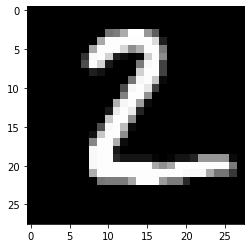

In [28]:
##ONNX load is not supported in pytorch
#re-load model from .pt for TVM check
model_infer = Net()
model_infer.load_state_dict(torch.load("mnist_cnn.pt"))

##check loaded model is working
import matplotlib.pyplot as plt
sample0, ref = dataset2[1]
plt.imshow(sample0.numpy()[0], cmap='gray')
print("target=",ref)
sample0 = sample0.view(1,1,28,28) #add batch1 dimension
infer_res = model_infer(sample0)
print("infer_res=",infer_res.argmax(dim=1, keepdim=False))

check_all_eneble = False
if check_all_eneble:
    test_batch1_kwargs = {'batch_size': 1}
    test_batch1_loader = torch.utils.data.DataLoader(dataset2, **test_batch1_kwargs)
    for data, target in test_batch1_loader:
        output = model_infer(data)
        pred = output.argmax(dim=1, keepdim=False)
        print("infer" , pred)
        print("ref" , target)

ONNX Load NNs

In [29]:
import onnx
# Load the ONNX model
model_onnx = onnx.load("example_onnx_tvm_mnist.onnx")

# Check that the model is well formed
onnx.checker.check_model(model_onnx)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model_onnx.graph))

graph torch-jit-export (
  %actual_input_1[FLOAT, 1x1x28x28]
) initializers (
  %conv1.weight[FLOAT, 32x1x3x3]
  %conv1.bias[FLOAT, 32]
  %conv2.weight[FLOAT, 64x32x3x3]
  %conv2.bias[FLOAT, 64]
  %fc1.weight[FLOAT, 128x9216]
  %fc1.bias[FLOAT, 128]
  %fc2.weight[FLOAT, 10x128]
  %fc2.bias[FLOAT, 10]
) {
  %x = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%actual_input_1, %conv1.weight, %conv1.bias)
  %input = Relu(%x)
  %x.3 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%input, %conv2.weight, %conv2.bias)
  %onnx::MaxPool_12 = Relu(%x.3)
  %input.4 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%onnx::MaxPool_12)
  %onnx::Gemm_14 = Flatten[axis = 1](%input.4)
  %x.7 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_14, %fc1.weight, %fc1.bias)
  %input.8 = Relu(%x.7)
  %x.11 = Gemm[alpha = 1, beta = 1, transB = 1](%input.8, %fc2.weight, %fc2.bias)
  %out

TVM compile test

In [60]:
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor
import numpy as np

input_name = "actual_input_1"

shape_dict = {input_name: dummy_input.shape}
mod, params = relay.frontend.from_onnx(model_onnx, shape_dict)

#initial Relay IR
print(mod.astext(show_meta_data=False))

target = tvm.target.Target("cuda", host="llvm")

with tvm.transform.PassContext(opt_level=1):
    lib = relay.build(mod, target=target, params=params)


#[version = "0.0.5"]
def @main(%actual_input_1: Tensor[(1, 1, 28, 28), float32]) -> Tensor[(1, 10), float32] {
  %0 = nn.conv2d(%actual_input_1, meta[relay.Constant][0] /* ty=Tensor[(32, 1, 3, 3), float32] */, padding=[0, 0, 0, 0], channels=32, kernel_size=[3, 3]) /* ty=Tensor[(1, 32, 26, 26), float32] */;
  %1 = nn.bias_add(%0, meta[relay.Constant][1] /* ty=Tensor[(32), float32] */) /* ty=Tensor[(1, 32, 26, 26), float32] */;
  %2 = nn.relu(%1) /* ty=Tensor[(1, 32, 26, 26), float32] */;
  %3 = nn.conv2d(%2, meta[relay.Constant][2] /* ty=Tensor[(64, 32, 3, 3), float32] */, padding=[0, 0, 0, 0], channels=64, kernel_size=[3, 3]) /* ty=Tensor[(1, 64, 24, 24), float32] */;
  %4 = nn.bias_add(%3, meta[relay.Constant][3] /* ty=Tensor[(64), float32] */) /* ty=Tensor[(1, 64, 24, 24), float32] */;
  %5 = nn.relu(%4) /* ty=Tensor[(1, 64, 24, 24), float32] */;
  %6 = nn.max_pool2d(%5, pool_size=[2, 2], strides=[2, 2], padding=[0, 0, 0, 0]) /* ty=Tensor[(1, 64, 12, 12), float32] */;
  %7 = nn.batch

In [61]:
#Cuda Print
source_module = lib.get_lib().imported_modules[0]

#LLVM print
#source_module = lib.get_lib()

source_code = source_module.get_source()
print(source_code)


#if defined(__CUDA_ARCH__) && (__CUDA_ARCH__ < 700)
#define __shfl_sync(mask, var, lane, width) \
        __shfl((var), (lane), (width))

#define __shfl_down_sync(mask, var, offset, width) \
        __shfl_down((var), (offset), (width))

#define __shfl_up_sync(mask, var, offset, width) \
        __shfl_up((var), (offset), (width))
#endif


#ifdef _WIN32
  using uint = unsigned int;
  using uchar = unsigned char;
  using ushort = unsigned short;
  using int64_t = long long;
  using uint64_t = unsigned long long;
#else
  #define uint unsigned int
  #define uchar unsigned char
  #define ushort unsigned short
  #define int64_t long long
  #define uint64_t unsigned long long
#endif
extern "C" __global__ void __launch_bounds__(1024) tvmgen_default_fused_nn_max_pool2d_kernel0(float* __restrict__ placeholder, float* __restrict__ tensor) {
  float tensor_local[1];
  tensor_local[0] = -3.402823e+38f;
  for (int rv0 = 0; rv0 < 2; ++rv0) {
    for (int rv1 = 0; rv1 < 2; ++rv1) {
      tensor_loca

In [64]:
#runtime
dev = tvm.cuda(0)
tvm_exec = graph_executor.GraphModule(lib["default"](dev))

# Set inputs
tvm_exec.set_input(input_name, tvm.nd.array(sample0.numpy().astype(dtype)))
# Execute
tvm_exec.run()
# Get outputs
tvm_output = tvm_exec.get_output(0)

print(np.argmax(tvm_output.numpy()[0]))


2


In [63]:
#relay graphical print
from typing import (
    Dict,
    Union,
    Tuple,
    List,
)
import tvm
from tvm import relay
from tvm.contrib import relay_viz
from tvm.contrib.relay_viz.interface import (
    VizEdge,
    VizNode,
    VizParser,
)
from tvm.contrib.relay_viz.terminal import (
    TermGraph,
    TermPlotter,
    TermVizParser,
)

viz = relay_viz.RelayVisualizer(mod)
viz.render()


@main([Var(actual_input_1, ty=TensorType([1, 1, 28, 28], float32))])
`--Call 
   |--subtract 
   |--Call 
   |  |--subtract 
   |  |--Call 
   |  |  |--add 
   |  |  |--Call 
   |  |  |  |--nn.dense 
   |  |  |  |--Call 
   |  |  |  |  |--nn.relu 
   |  |  |  |  `--Call 
   |  |  |  |     |--add 
   |  |  |  |     |--Call 
   |  |  |  |     |  |--nn.dense 
   |  |  |  |     |  |--Call 
   |  |  |  |     |  |  |--nn.batch_flatten 
   |  |  |  |     |  |  `--Call 
   |  |  |  |     |  |     |--nn.max_pool2d 
   |  |  |  |     |  |     `--Call 
   |  |  |  |     |  |        |--nn.relu 
   |  |  |  |     |  |        `--Call 
   |  |  |  |     |  |           |--nn.bias_add 
   |  |  |  |     |  |           |--Call 
   |  |  |  |     |  |           |  |--nn.conv2d 
   |  |  |  |     |  |           |  |--Call 
   |  |  |  |     |  |           |  |  |--nn.relu 
   |  |  |  |     |  |           |  |  `--Call 
   |  |  |  |     |  |           |  |     |--nn.bias_add 
   |  |  |  |     |  |      